# **<center>Práctica: Adversarial Examples</center>**

### **1. Introducción**
Los ejemplos adversarios (Adversarial Examples - AE) en redes neuronales han puesto recientemente en duda la robustez de dichas funciones, al ser capaces de cambiar la predicción de una red sin más que perturbar mínimamente los datos de entrada.

### **2. PGD**
En este notebook nos centraremos en un ataque no dirigido (**Non-targeted attack**). Para ello, primero definiremos correctamente el problema de encontrar la perturbación óptima para un ejemplo (imagen) dado. Se trata, por tanto, de encontar la perturbación δ que maximiza la pérdida:
$$
\delta^* = \mbox{arg}\min_{\delta \in \Delta} \mathcal{L} (y, f(\theta ,x + \delta))
$$
es un conjunto restringido de $\delta$:
$$ 
\Delta = \{\delta: ||\delta||_{\infty} \leq \epsilon\}
$$

Es decir, se busca $\delta^∗$ que maximiza la pérdida $\mathcal{L}$ con la restricción de que $\delta \in \Delta$  tenga una norma infinito menor que cierto valor $\epsilon$. Intuitivamente, esto significa que cada píxel de la imagen puede ser modificado hasta un cierto $\delta$. Por ejemplo, si el valor de un píxel es 0.5, y $\delta$ = 0.1, el rango de posibles valores de $\delta$ sería $[−0.1, 0.1]$ y, por tanto, el rango de posibles valores del píxel sería $[0.4, 0.6]$.

Paper: [Towards Deep Learning Models Resistant to Adversarial Attacks](https://arxiv.org/pdf/1706.06083.pdf) - Madry et al 2017

In [1]:
import torch
import torch.nn.functional as F

from torch import nn, optim 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

## Modelo

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(12544 , 512)
        self.fc2 = nn.Linear(512 , 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)

        x = torch.flatten(x, 1) 
        x = self.dropout2(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Entrenamos un clasificador para CIFAR10

In [4]:
!pip install ml_collections

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for ml_collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=76ce49f55dbf1261c4c7e0bf38b0e6aa4bdecf095590173e4438646335d06df8
  Stored in directory: /root/.cache/pip/wheels/b7/da/64/33c926a1b10ff19791081b705879561b715a8341a856a3bbd2
Successfully built ml_collections


In [5]:
from ml_collections import ConfigDict

device = 'cuda'

args = ConfigDict()
args.batch_size = 64
args.test_batch_size = 1024
args.epochs = 20
args.log_interval = 10
args.lr = 1e-3

In [6]:
transform=transforms.Compose([ transforms.ToTensor(),])

train_ds = datasets.CIFAR10('../data', train=True, download=True, transform=transform)
test_ds = datasets.CIFAR10('../data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=args.batch_size)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=args.test_batch_size)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=args.lr)

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.314045
Train Epoch: 1 [640/50000 (1%)]	Loss: 2.311815
Train Epoch: 1 [1280/50000 (3%)]	Loss: 2.215961
Train Epoch: 1 [1920/50000 (4%)]	Loss: 2.258940
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.102873
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.041293
Train Epoch: 1 [3840/50000 (8%)]	Loss: 1.996330
Train Epoch: 1 [4480/50000 (9%)]	Loss: 2.142147
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.009538
Train Epoch: 1 [5760/50000 (12%)]	Loss: 1.958246
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.776176
Train Epoch: 1 [7040/50000 (14%)]	Loss: 1.746470
Train Epoch: 1 [7680/50000 (15%)]	Loss: 1.747875
Train Epoch: 1 [8320/50000 (17%)]	Loss: 1.821811
Train Epoch: 1 [8960/50000 (18%)]	Loss: 2.079463
Train Epoch: 1 [9600/50000 (19%)]	Loss: 1.774200
Train Epoch: 1 [10240/50000 (20%)]	Loss: 1.753921
Train Epoch: 1 [10880/50000 (22%)]	Loss: 1.963209
Train Epoch: 1 [11520/50000 (23%)]	Loss: 1.521765
Train Epoch: 1 [12160/500

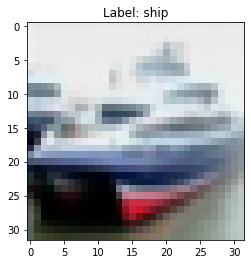

In [7]:
idx = 1
x = test_ds.data[idx,...]
y = test_ds.targets[idx]

plt.title('Label: '+ test_ds.classes[y])
plt.imshow(x);

## Ejemplo de ataque PGD l$\infty$ con 100 iteraciones y $\epsilon$ = 0.05

In [8]:
# Función para generar imagenes adversarias con algoritmo PGD
def pgd_attack(model, image, label, eps=0.05, iter=100, alpha=1/255, device='cuda'):

    image, label = image.to(device), label.to(device)
  
    x_adv = image.requires_grad_(True).to(device)

    for _ in range(iter):    
        y_adv = model(x_adv)

        loss = F.nll_loss(y_adv, label)
        grad = torch.autograd.grad(loss, x_adv)[0]

        # Non-targeret
        x_adv = x_adv + alpha * torch.sign(grad)
        
        delta = torch.clamp(x_adv - image, min=-eps, max=eps)
        x_adv = torch.clamp(image + delta, min=0, max=1)
            
    return x_adv

In [15]:
def visulize_adv(idx):
    x, y = next(iter(test_loader))
    x = x[idx:idx+1,...]
    y = y[idx:idx+1,...]

    x_adv = pgd_attack(model, x, y, eps=0.05, iter=100)
    y_adv = model(x_adv)

    x_adv = x_adv.permute(0,2,3,1)[0].detach().cpu().numpy()
    x = x.permute(0,2,3,1)[0].detach().cpu().numpy()

    fig, axs = plt.subplots(1,2, figsize=(15,5))

    axs[0].set_title('Predicted Label: '+ str(test_ds.classes[y]))
    axs[0].imshow(x)
    axs[1].set_title('Adv Label: '+ str(test_ds.classes[y_adv[0].argmax().cpu().numpy()]))

    axs[1].imshow(x_adv)

    plt.show()

## Ejemplo de las imágenes adversarias generadas. 

En las figuras de abajo se pueden ver varios ejemplos de imágenes adversarias generadas, donde el resultado obtenido es diferentes a la etiqueta original. 

Después, en el notebook, se ha realizado un test del modelo con 1000 imágenes de validación tras aplicarles la perturbación. El modelo solo es capaz de acertar 7 imagenes en comparación a 7098 de las imágenes sin procesar.  

En conclusión, se puede decir que el modelo es muy frágil ante ataques adversarios, y el ataque PGD cumple su objetivo en la gran mayoria de casos. 

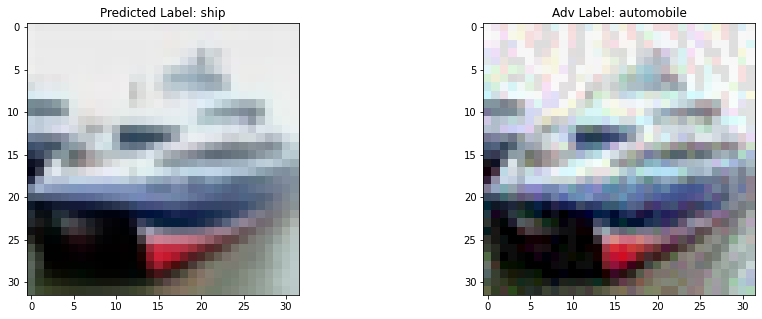

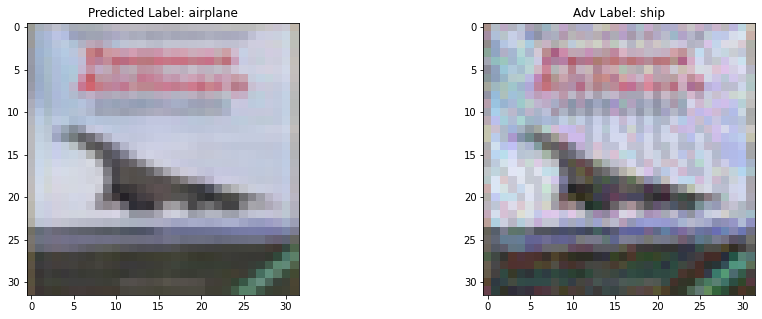

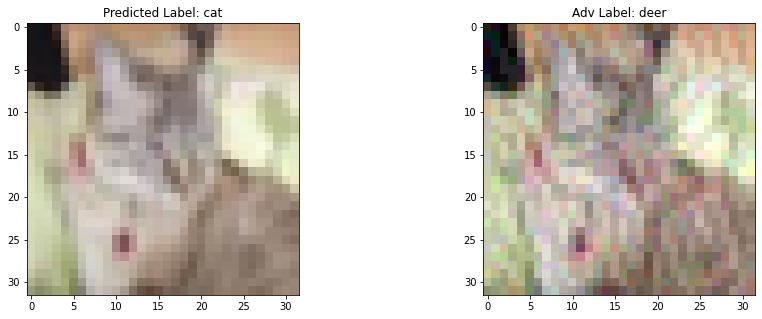

In [19]:
visulize_adv(1)
visulize_adv(3)
visulize_adv(8)

## Entrenamiento adversario haciendo uso de un ataque PGD l$\infty$

In [20]:
def adv_test(model, device, test_loader, ep = 0.05):
    model.eval()
    test_loss, correct = 0, 0
    for data, target in test_loader:
        data, target = data.to(device).requires_grad_(True), target.to(device)
        
        x_adv = pgd_attack(model, data, target, eps=ep, iter=100)

        with torch.no_grad():
            y_hat_adv = model(x_adv)

            pred = y_hat_adv.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)

    print('Test set: Accuracy: {}/{} ({:.0f}%)'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [21]:
test(model, device, test_loader)
adv_test(model, device, test_loader, ep = 0.05)


Test set: Average loss: 0.9614, Accuracy: 7098/10000 (71%)

Test set: Accuracy: 6/10000 (0%)


In [22]:
def adv_train(args, model, device, train_loader, optimizer, epoch, ep = 0.05):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = nn.Parameter(data)
        
        x_adv = pgd_attack(model, data, target, eps=ep, iter=100)

        data = x_adv.detach()


        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
model_adv = Net().to(device)

optimizer_adv = optim.Adam(model_adv.parameters(), lr=args.lr)

for epoch in range(1, args.epochs + 1):
    adv_train(args, model_adv, device, train_loader, optimizer_adv, epoch)
    test(model_adv, device, test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.324614
Train Epoch: 1 [640/50000 (1%)]	Loss: 2.303994
Train Epoch: 1 [1280/50000 (3%)]	Loss: 2.306145
Train Epoch: 1 [1920/50000 (4%)]	Loss: 2.292983
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.296203
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.267502
Train Epoch: 1 [3840/50000 (8%)]	Loss: 2.278759
Train Epoch: 1 [4480/50000 (9%)]	Loss: 2.280731
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.297971
Train Epoch: 1 [5760/50000 (12%)]	Loss: 2.305672
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.261037
Train Epoch: 1 [7040/50000 (14%)]	Loss: 2.257538
Train Epoch: 1 [7680/50000 (15%)]	Loss: 2.288114
Train Epoch: 1 [8320/50000 (17%)]	Loss: 2.261921
Train Epoch: 1 [8960/50000 (18%)]	Loss: 2.283876
Train Epoch: 1 [9600/50000 (19%)]	Loss: 2.232472
Train Epoch: 1 [10240/50000 (20%)]	Loss: 2.202292
Train Epoch: 1 [10880/50000 (22%)]	Loss: 2.187730
Train Epoch: 1 [11520/50000 (23%)]	Loss: 2.187340
Train Epoch: 1 [12160/50000 (24%)]	Loss: 2.209400
Train Epoch: 1 [12800/50000 

In [23]:
print('\nModelo entrenado con imágenes "normales"')
print(' --> Evaluacion con imágenes "normales"')
adv_test(model, device, test_loader, ep = 0/255)
print(' --> Evaluacion con imágenes adversarias')
adv_test(model, device, test_loader, ep = 8/255)

print('\nModelo entrenado con imágenes adversarias')
print(' --> Evaluacion con imágenes "normales"')
adv_test(model_adv, device, test_loader, ep = 0/255)
print(' --> Evaluacion con imágenes adversarias')
adv_test(model_adv, device, test_loader, ep = 8/255)


Modelo entrenado con imágenes "normales"
 --> Evaluacion con imágenes "normales"
Test set: Accuracy: 7098/10000 (71%)
 --> Evaluacion con imágenes adversarias
Test set: Accuracy: 10/10000 (0%)

Modelo entrenado con imágenes adversarias
 --> Evaluacion con imágenes "normales"
Test set: Accuracy: 3607/10000 (36%)
 --> Evaluacion con imágenes adversarias
Test set: Accuracy: 2794/10000 (28%)


# Conclusión
En este notebook se han realizado las siguientes tareas: 

1. Se ha entrenado un **modelo con imágenes de la base de datos CIFAR10 dando como resultado un 71% de acierto**.
2. Se ha creado una **función capaz de generar ataques adversarios PGD con $l_\infty$**. Esta función se ha probado con el modelo entrenado con imagenes CIFAR10 acertando un 0% de las imágenes adversarias (10/10000 imágenes). Se ha observado que, utilizando el ataque PGD con 100 iteracion y $\epsilon$ = 0.05, la precisión del modelo es bajísima, logrando "engañar" al modelo casi en la totalidad de las imágenes generadas.
3. Utilizando el mismo modelo anterior, esta vez se ha **entrenado con las imágenes adversarias** generadas para estudiar su resultado. 
* Se observa que **la precisión de la red evaluada con imágenes CIFAR10 disminuye a 36%**. Esto podría deberse a que la perturbación que genenera el ataque PGD a las imágenes de entrenamiento hace que sean sustancialmente diferentes a las imágenes del dataset. Para solucionar la baja precisión de la red se podría probar a entrenar el modelo con las imágenes adversarias y las imágenes del dataset CIFAR10, o elegir una red que fuera más adecuada para este tipo de datos ya que se ha utilizado una red muy general para el ejercicio.
* **La precisión de la red evaluada con imágenes adversarias es del 28%**. Como se podía esperar, el resultado sería muy superior al modelo entrenado con imágenes CIFAR10 y evaluado con imágenes adversarias. Esta red ha sido entrenada con imágenes adversarias, por lo que mejora el resultado con este tipo de imágenes, aunque los resultados siguen siendo bastante bajos. Como se ha comentado en el punto anterior, seguramente sería interesante hacer un entrenamiento con imagenes del dataset y adversarias para probar si mejoran los resultados.